# Soccer Science

## Setup

### Import the Data

Import all necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import scipy
import numpy as np
import datetime
import xgboost as xgb
import pickle

from pivottablejs import pivot_ui
from IPython.display import display
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score


Load the data. Note that the **date is first** (British format)

In [2]:
df_raw = pd.read_csv("..//Data/2015_2020_William_hill.csv", parse_dates=["Date"], dayfirst=True)
df_names = pd.read_csv("..//Data/teams_to_numbers_MD.csv")
df_names1516 = pd.read_csv("..//Data/teams_to_numbers1516_MD.csv")
df_names1617 = pd.read_csv("..//Data/teams_to_numbers1617_MD.csv")
df_names1718 = pd.read_csv("..//Data/teams_to_numbers1718_MD.csv")
df_names1819 = pd.read_csv("..//Data/teams_to_numbers1819_MD.csv")
df_names1920 = pd.read_csv("..//Data/teams_to_numbers1920_MD.csv")

### Extract Year and Month

Look at **all** data using info, describe and head.
We can check for NAN / null values in info.

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Add more information to the datetime feature

In [4]:
df_raw['year'] = pd.DatetimeIndex(df_raw['Date']).year
df_raw['month'] = pd.DatetimeIndex(df_raw['Date']).month

In [5]:
df_raw.head(10)

,Date,HomeTeam,AwayTeam,outcome_by_HOME,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month
0,2015-08-08,Bournemouth,Aston Villa,A,1.91,3.5,4.00,2015,8
1,2015-08-08,Chelsea,Swansea,D,1.40,4.0,10.00,2015,8
2,2015-08-08,Everton,Watford,D,1.73,3.5,5.00,2015,8
3,2015-08-08,Leicester,Sunderland,H,2.00,3.1,2.70,2015,8
4,2015-08-08,Man United,Tottenham,H,1.62,3.6,6.00,2015,8
5,2015-08-08,Norwich,Crystal Palace,A,2.60,3.1,2.88,2015,8
6,2015-08-09,Arsenal,West Ham,A,1.30,5.0,11.00,2015,8
7,2015-08-09,Newcastle,Southampton,D,2.70,3.1,2.70,2015,8
8,2015-08-09,Stoke,Liverpool,A,3.30,3.1,2.30,2015,8
9,2015-08-10,West Brom,Man City,A,5.50,3.5,1.70,2015,8


In [6]:
df_raw.describe()

,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month
count,1770.000000,1770.000000,1770.000000,1900.000000,1900.000000
mean,2.942164,4.031136,4.996678,2017.481053,6.751579
std,2.296751,1.336752,4.637151,1.489708,3.945571
min,1.050000,2.800000,1.120000,2015.000000,1.000000
25%,1.670000,3.250000,2.350000,2016.000000,3.000000
50%,2.250000,3.500000,3.300000,2017.000000,8.000000
75%,3.100000,4.200000,5.500000,2019.000000,11.000000
max,21.000000,13.000000,46.000000,2020.000000,12.000000


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 9 columns):
Date                        1900 non-null datetime64[ns]
HomeTeam                    1900 non-null object
AwayTeam                    1900 non-null object
outcome_by_HOME             1770 non-null object
AVERAGE_ODD_WIN             1770 non-null float64
AVERAGE_ODD_DRAW            1770 non-null float64
AVERAGE_ODD_OPPONENT_WIN    1770 non-null float64
year                        1900 non-null int64
month                       1900 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 133.7+ KB


### Make Catagorical Features Numerical and add Team Information

There are no null items, but there are strings which need to be turned into catagorical data: team name and outcome. And we want the "last game" number to be consistent with the W, D, L of the "outcome"

In [8]:
df_raw['outcome_by_HOME'] = df_raw.outcome_by_HOME.astype('category')

In [9]:
# Make Home wins: 2; Draw: 1 and Away Team Wins: 0
df_raw = df_raw.replace('H', 2)
df_raw = df_raw.replace('D', 1)
df_raw = df_raw.replace('A', 0)

In [10]:
# Add Home Team Previous season results
df_num = df_names.merge(df_raw, left_on='Team', right_on='HomeTeam');
df_num = df_num.drop(['Team'], axis=1)



In [11]:
df_num.rename(columns = {'Av_Salary_Club':'H_Av_Salary_Club',
                         'Draw':'H_Draw',
                         'Goals_For':'H_Goals_For',
                         'Goal_Difference':'H_Goal_Difference'},
              inplace = True)

In [12]:
df_num.rename(columns = {'Team_Number':'H_Team_number'}, inplace = True)

In [13]:
df_num2 = df_names.merge(df_num, left_on='Team', right_on='AwayTeam');
df_num2 = df_num2.drop(['Team'], axis=1)

In [14]:
# Add Away Team Previous season results
df_num2.rename(columns = {'Av_Salary_Club':'A_Av_Salary_Club',
                         'Draw':'A_Draw',
                         'Goals_For':'A_Goals_For',
                         'Goal_Difference':'A_Goal_Difference'},
              inplace = True)

In [15]:
df_num2.rename(columns = {'Team_Number':'A_Team_number'}, inplace = True)

In [16]:
df_num2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 0 to 1899
Data columns (total 19 columns):
A_Team_number               1900 non-null int64
A_Av_Salary_Club            1900 non-null float64
A_Draw                      1900 non-null int64
A_Goals_For                 1900 non-null int64
A_Goal_Difference           1900 non-null int64
H_Team_number               1900 non-null int64
H_Av_Salary_Club            1900 non-null float64
H_Draw                      1900 non-null int64
H_Goals_For                 1900 non-null int64
H_Goal_Difference           1900 non-null int64
Date                        1900 non-null datetime64[ns]
HomeTeam                    1900 non-null object
AwayTeam                    1900 non-null object
outcome_by_HOME             1770 non-null float64
AVERAGE_ODD_WIN             1770 non-null float64
AVERAGE_ODD_DRAW            1770 non-null float64
AVERAGE_ODD_OPPONENT_WIN    1770 non-null float64
year                        1900 non-null int64
month 

In [17]:
# Add a random number to help with feature selection
df_num2['RandomNumber'] = np.random.randint(1, df_num2.shape[0], df_num2.shape[0])


In [18]:
df_num2 = df_num2.sort_values(by=['Date'])
df_num2 = df_num2.reset_index(drop=True)


In [19]:
df_num2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 20 columns):
A_Team_number               1900 non-null int64
A_Av_Salary_Club            1900 non-null float64
A_Draw                      1900 non-null int64
A_Goals_For                 1900 non-null int64
A_Goal_Difference           1900 non-null int64
H_Team_number               1900 non-null int64
H_Av_Salary_Club            1900 non-null float64
H_Draw                      1900 non-null int64
H_Goals_For                 1900 non-null int64
H_Goal_Difference           1900 non-null int64
Date                        1900 non-null datetime64[ns]
HomeTeam                    1900 non-null object
AwayTeam                    1900 non-null object
outcome_by_HOME             1770 non-null float64
AVERAGE_ODD_WIN             1770 non-null float64
AVERAGE_ODD_DRAW            1770 non-null float64
AVERAGE_ODD_OPPONENT_WIN    1770 non-null float64
year                        1900 non-null int64
month 

In [20]:
# We don't have all the 2020 data yet, so they will be '0's (and not included in the model / test)
df_num2.fillna(value=0, inplace=True)
df_num2.tail()

,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,Date,HomeTeam,AwayTeam,outcome_by_HOME,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
1895,19,0.65,92,365,-145,15,5.99,196,1374,399,2020-05-17,Man City,Norwich,0.0,0.0,0.0,0.0,2020,5,1763
1896,29,1.76,49,203,-124,7,5.02,257,1770,768,2020-05-17,Chelsea,Wolves,0.0,0.0,0.0,0.0,2020,5,662
1897,26,1.78,51,240,-137,1,4.85,260,1845,832,2020-05-17,Arsenal,Watford,0.0,0.0,0.0,0.0,2020,5,296
1898,3,1.99,36,201,-64,9,3.25,296,1357,46,2020-05-17,Everton,Bournemouth,0.0,0.0,0.0,0.0,2020,5,37
1899,16,6.53,224,1989,1060,13,2.71,136,623,-95,2020-05-17,Leicester,Man United,0.0,0.0,0.0,0.0,2020,5,897


### Split Data into Seasons / Years, Add Seasonal Information

In [21]:
df = df_num2

In [22]:
df_2015B = df[(df["year"]==2015) & (df["month"]>=7)]
df_2016A = df[(df["year"]==2016) & (df["month"]<7)]
df_2016B = df[(df["year"]==2016) & (df["month"]>=7)]
df_2017A = df[(df["year"]==2017) & (df["month"]<7)]
df_2017B = df[(df["year"]==2017) & (df["month"]>=7)]
df_2018A = df[(df["year"]==2018) & (df["month"]<7)]
df_2018B = df[(df["year"]==2018) & (df["month"]>=7)]
df_2019A = df[(df["year"]==2019) & (df["month"]<7)]
df_2019B = df[(df["year"]==2019) & (df["month"]>=7)]
df_2020A = df[(df["year"]==2020) & (df["month"]<7)]

In [23]:
# splitting into seasons
df_15B16A = pd.concat([df_2015B, df_2016A], sort=False)
df_16B17A = pd.concat([df_2016B, df_2017A], sort=False)
df_17B18A = pd.concat([df_2017B, df_2018A], sort=False)
df_18B19A = pd.concat([df_2018B, df_2019A], sort=False)
df_19B20A = pd.concat([df_2019B, df_2020A], sort=False)


In [24]:
# Add Home team information
df_15B16A_sal = df_names1516.merge(df_15B16A, left_on='Team_Number', right_on='H_Team_number');
df_15B16A_sal = df_15B16A_sal.drop(['Team_Number', 'Team'], axis=1)
df_16B17A_sal = df_names1617.merge(df_16B17A, left_on='Team_Number', right_on='H_Team_number');
df_16B17A_sal = df_16B17A_sal.drop(['Team_Number', 'Team'], axis=1)
df_17B18A_sal = df_names1718.merge(df_17B18A, left_on='Team_Number', right_on='H_Team_number');
df_17B18A_sal = df_17B18A_sal.drop(['Team_Number', 'Team'], axis=1)
df_18B19A_sal = df_names1819.merge(df_18B19A, left_on='Team_Number', right_on='H_Team_number');
df_18B19A_sal = df_18B19A_sal.drop(['Team_Number', 'Team'], axis=1)
df_19B20A_sal = df_names1920.merge(df_19B20A, left_on='Team_Number', right_on='H_Team_number');
df_19B20A_sal = df_19B20A_sal.drop(['Team_Number', 'Team'], axis=1)

In [25]:
df_15B16A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)

df_16B17A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)

df_17B18A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)

df_18B19A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)

df_19B20A_sal.rename(columns = {'Pos':'HSeas_Pos',
                         'Draw':'HSeas_Draw',
                         'Goals_For':'HSeas_Goals_For',
                         'Goal_Difference':'HSeas_Goal_Difference',
                         'Pts':'HSeas_Pts'},
              inplace = True)


In [26]:
# Add Away team information
df_15B16A_sal2 = df_names1516.merge(df_15B16A_sal, left_on='Team_Number', right_on='A_Team_number');
df_15B16A_sal2 = df_15B16A_sal2.drop(['Team_Number', 'Team'], axis=1)
df_16B17A_sal2 = df_names1617.merge(df_16B17A_sal, left_on='Team_Number', right_on='A_Team_number');
df_16B17A_sal2 = df_16B17A_sal2.drop(['Team_Number', 'Team'], axis=1)
df_17B18A_sal2 = df_names1718.merge(df_17B18A_sal, left_on='Team_Number', right_on='A_Team_number');
df_17B18A_sal2 = df_17B18A_sal2.drop(['Team_Number', 'Team'], axis=1)
df_18B19A_sal2 = df_names1819.merge(df_18B19A_sal, left_on='Team_Number', right_on='A_Team_number');
df_18B19A_sal2 = df_18B19A_sal2.drop(['Team_Number', 'Team'], axis=1)
df_19B20A_sal2 = df_names1920.merge(df_19B20A_sal, left_on='Team_Number', right_on='A_Team_number');
df_19B20A_sal2 = df_19B20A_sal2.drop(['Team_Number', 'Team'], axis=1)

In [27]:
df_15B16A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

df_16B17A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

df_17B18A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

df_18B19A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

df_19B20A_sal2.rename(columns = {'Pos':'ASeas_Pos',
                         'Draw':'ASeas_Draw',
                         'Goals_For':'ASeas_Goals_For',
                         'Goal_Difference':'ASeas_Goal_Difference',
                         'Pts':'ASeas_Pts'},
              inplace = True)

In [28]:
df_15B16A_sal2 = df_15B16A_sal2.sort_values(by=['Date'])
df_15B16A_sal2 = df_15B16A_sal2.reset_index(drop=True)

df_16B17A_sal2 = df_16B17A_sal2.sort_values(by=['Date'])
df_16B17A_sal2 = df_16B17A_sal2.reset_index(drop=True)

df_17B18A_sal2 = df_17B18A_sal2.sort_values(by=['Date'])
df_17B18A_sal2 = df_17B18A_sal2.reset_index(drop=True)

df_18B19A_sal2 = df_18B19A_sal2.sort_values(by=['Date'])
df_18B19A_sal2 = df_18B19A_sal2.reset_index(drop=True)

df_19B20A_sal2 = df_19B20A_sal2.sort_values(by=['Date'])
df_19B20A_sal2 = df_19B20A_sal2.reset_index(drop=True)


In [29]:
df_15B161718A_sal2 = pd.concat([df_15B16A_sal2, df_16B17A_sal2, df_17B18A_sal2], sort=False)
df_15B161718A_sal2 = df_15B161718A_sal2.sort_values(by=['Date'])
df_15B161718A_sal2 = df_15B161718A_sal2.reset_index(drop=True)

In [30]:
df_19B20A_sal2_test = df_19B20A_sal2.iloc[0:250]

In [31]:
y_19B20A_output = df_19B20A_sal2.outcome_by_HOME
df_19B20A_output = df_19B20A_sal2.drop(['outcome_by_HOME', 'Date', 'HomeTeam', 'AwayTeam'], axis=1)


### Define Training/Valid/Test Datasets

Our training data set = 2015/2016, 2016/2017, 2017/2018 seasons
Validation data set = 2018/2019 season
Test data set = 2019/2020 season

In [32]:
y_15B161718A = df_15B161718A_sal2.outcome_by_HOME
y_18B19A = df_18B19A_sal2.outcome_by_HOME
y_19B20A = df_19B20A_sal2_test.outcome_by_HOME
df_15B161718A = df_15B161718A_sal2.drop(['outcome_by_HOME', 'Date', 'HomeTeam', 'AwayTeam'], axis=1)
df_18B19A = df_18B19A_sal2.drop(['outcome_by_HOME', 'Date', 'HomeTeam', 'AwayTeam'], axis=1)
df_19B20A = df_19B20A_sal2_test.drop(['outcome_by_HOME', 'Date', 'HomeTeam', 'AwayTeam'], axis=1)



In [33]:
X_train = df_15B161718A
y_train = y_15B161718A

In [34]:
df_19B20A_sal2_test.tail()

,ASeas_Pos,ASeas_Draw,ASeas_Goals_For,ASeas_Goal_Difference,ASeas_Pts,HSeas_Pos,HSeas_Draw,HSeas_Goals_For,HSeas_Goal_Difference,HSeas_Pts,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,Date,HomeTeam,AwayTeam,outcome_by_HOME,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
245,0,0,0,0,0,14,6,56,-14,45,2,1.30,275,1117,-69,3,1.99,36,201,-64,2020-02-01,Bournemouth,Aston Villa,2.0,2.15,3.50,3.40,2020,2,1601
246,0,0,0,0,0,12,7,51,-2,49,20,0.62,36,128,-40,8,2.76,96,425,-139,2020-02-01,Crystal Palace,Sheffield United,0.0,3.10,3.10,2.50,2020,2,701
247,16,12,45,-20,39,2,7,89,67,97,21,2.67,214,937,-150,14,4.86,262,1774,728,2020-02-01,Liverpool,Southampton,2.0,1.27,5.80,11.00,2020,2,904
248,5,7,73,22,70,15,7,45,-23,40,1,4.85,260,1845,832,5,1.60,44,190,-107,2020-02-02,Burnley,Arsenal,1.0,3.75,3.50,2.00,2020,2,1
249,1,2,95,72,98,4,2,67,28,71,15,5.99,196,1374,399,25,3.52,257,1547,241,2020-02-02,Tottenham,Man City,2.0,5.80,4.33,1.55,2020,2,1326


df_18B19A = validation data; df_19B20A = test data (with y_18B19A and y_19B20A being the corresponding results)

In [35]:
X_valid = df_18B19A
y_valid = y_18B19A
X_test = df_19B20A
y_test = y_19B20A

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. You can construct DMatrix from numpy.arrays

In [36]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [37]:
y_test.tail()

245    2.0
246    0.0
247    2.0
248    1.0
249    2.0
Name: outcome_by_HOME, dtype: float64

In [38]:
X_test.tail()

,ASeas_Pos,ASeas_Draw,ASeas_Goals_For,ASeas_Goal_Difference,ASeas_Pts,HSeas_Pos,HSeas_Draw,HSeas_Goals_For,HSeas_Goal_Difference,HSeas_Pts,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
245,0,0,0,0,0,14,6,56,-14,45,2,1.30,275,1117,-69,3,1.99,36,201,-64,2.15,3.50,3.40,2020,2,1601
246,0,0,0,0,0,12,7,51,-2,49,20,0.62,36,128,-40,8,2.76,96,425,-139,3.10,3.10,2.50,2020,2,701
247,16,12,45,-20,39,2,7,89,67,97,21,2.67,214,937,-150,14,4.86,262,1774,728,1.27,5.80,11.00,2020,2,904
248,5,7,73,22,70,15,7,45,-23,40,1,4.85,260,1845,832,5,1.60,44,190,-107,3.75,3.50,2.00,2020,2,1
249,1,2,95,72,98,4,2,67,28,71,15,5.99,196,1374,399,25,3.52,257,1547,241,5.80,4.33,1.55,2020,2,1326


## Modelling with RF and Log Reg and Parameter Tuning

### Hyperparameter Optimization Random Forest: Grid Search

In [39]:
# print_score returns RMSE and accuracy. I am focusing on accuracy as my metric of choice
def rmse(x,y): return np.sqrt(((x-y)**2).mean())
def print_score(clf, X_train, y_train, X_valid, y_valid):
    res = [rmse(clf.predict(X_train), y_train),
           rmse(clf.predict(X_valid), y_valid),
           clf.score(X_train, y_train), clf.score(X_valid, y_valid)]
    if hasattr(clf, 'oob_score_'): res.append(clf.oob_score_)
    print(res)

In [40]:
X_valid.head()

,ASeas_Pos,ASeas_Draw,ASeas_Goals_For,ASeas_Goal_Difference,ASeas_Pts,HSeas_Pos,HSeas_Draw,HSeas_Goals_For,HSeas_Goal_Difference,HSeas_Pts,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
0,9,11,56,-4,47,2,6,68,40,81,13,2.71,136,623,-95,16,6.53,224,1989,1060,1.57,3.8,6.00,2018,8,1115
1,0,0,0,0,0,12,11,45,-16,44,6,0.96,13,66,-77,3,1.99,36,201,-64,1.91,3.5,4.00,2018,8,719
2,3,8,74,38,77,10,8,39,-8,44,25,3.52,257,1547,241,18,1.65,234,1249,14,3.80,3.2,2.05,2018,8,479
3,8,10,44,-14,49,0,0,0,0,0,9,3.25,296,1357,46,29,1.76,49,203,-124,2.30,3.2,3.20,2018,8,766
4,11,11,45,-10,44,0,0,0,0,0,8,2.76,96,425,-139,10,1.73,141,604,-174,2.45,3.3,2.80,2018,8,1715


In [41]:
clf_default = RandomForestClassifier(random_state=1)
clf_default.fit(X_train, y_train)
print_score(clf_default, X_train, y_train, X_valid, y_valid)

[0.0, 0.9933992677987828, 1.0, 0.5578947368421052]


Model is very overfit to training data

In [42]:
forest = RandomForestClassifier(random_state=1)

n_estimators = [50, 100, 150]
max_depth = [1, 5, 10, 15, 20, 25]
min_samples_split = [1, 2, 3, 4, 5]
min_samples_leaf = [1, 6, 12, 18, 24] 
bootstrap = ['False', 'True'] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,
              bootstrap = bootstrap)

gridF = GridSearchCV(forest, hyperF, verbose = 1, cv=4, n_jobs = -1, scoring='accuracy')
bestF = gridF.fit(X_train, y_train)

Fitting 4 folds for each of 900 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  3.8min finished


In [43]:
print(f'Best: {bestF.best_score_} using {bestF.best_params_}','\n')



Best: 0.5385964912280702 using {'bootstrap': 'False', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} 



In [165]:
clf = RandomForestClassifier(random_state=1, n_jobs=-1, max_depth=5, min_samples_leaf=12, min_samples_split=2, n_estimators=100, bootstrap='False')
clf.fit(X_train, y_train)
print_score(clf, X_train, y_train, X_valid, y_valid)



[0.9403246919632545, 1.0234101919819987, 0.6026315789473684, 0.5842105263157895]


Doing some hyperparameter tuning on the random forest, predominantly decreasing the max depth, decreases the variance and makes the model generalize better

### Logistic Regression Parameter Tuning

In [45]:
clf_LR_default = LogisticRegression(random_state=1).fit(X_train, y_train)
print(clf_LR_default.score(X_train, y_train))

predictions = clf_LR_default.predict(X_valid)
print(accuracy_score(y_valid, predictions))


0.5350877192982456
0.5842105263157895


/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [46]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'sag']
c_values = [100, 10, 1.0, 0.1, 0.01]
multi_class= ['multinomial', 'ovr']

# define grid search
grid = dict(solver=solvers,C=c_values, multi_class=multi_class)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridg

Best: 0.528655 using {'C': 0.1, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.519883 (0.020947) with: {'C': 100, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.519298 (0.018400) with: {'C': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
0.522515 (0.018481) with: {'C': 100, 'multi_class': 'multinomial', 'solver': 'sag'}
0.526023 (0.023989) with: {'C': 100, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.511696 (0.018668) with: {'C': 100, 'multi_class': 'ovr', 'solver': 'lbfgs'}
0.525731 (0.017239) with: {'C': 100, 'multi_class': 'ovr', 'solver': 'sag'}
0.519883 (0.020947) with: {'C': 10, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.518713 (0.017824) with: {'C': 10, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
0.521930 (0.018239) with: {'C': 10, 'multi_class': 'multinomial', 'solver': 'sag'}
0.526316 (0.024603) with: {'C': 10, 'multi_class': 'ovr', 'solver': 'newton-cg'}
0.516082 (0.017157) with: {'C': 10, 'multi_class': 'ovr', 'solver': 'lbfgs'}
0.525439 (0.

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastro

In [47]:
clf_LG = LogisticRegression(random_state=1, multi_class='ovr', solver='newton-cg', C=1.0).fit(X_train, y_train)
print(clf_LG.score(X_train, y_train))

predictions = clf_LG.predict(X_valid)
print(accuracy_score(y_valid, predictions))


/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridg

0.5622807017543859
0.5605263157894737


/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastro

After parameter tuning, the model generalizes well on the training and validation dataset

### Model Selection

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridg

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridg

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/fionastro

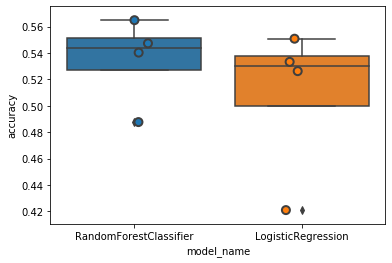

model_name
LogisticRegression        0.507895
RandomForestClassifier    0.535088
Name: accuracy, dtype: float64


In [172]:
#%matplotlib qt
models = [
    RandomForestClassifier(random_state=1, n_jobs=-1, max_depth=5, min_samples_leaf=12, min_samples_split=2, n_estimators=100, bootstrap='False'),
    LogisticRegression(random_state=1, multi_class='ovr', solver='newton-cg', C=1.0)
]
CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

print(cv_df.groupby('model_name').accuracy.mean())


After parameter tuning, comparing the models; the random forest has better accuracy than the logistic regression

## Feature Importance and Selection with RF and Log Reg using Hierarchical Clustering

### Hierarchical clustering

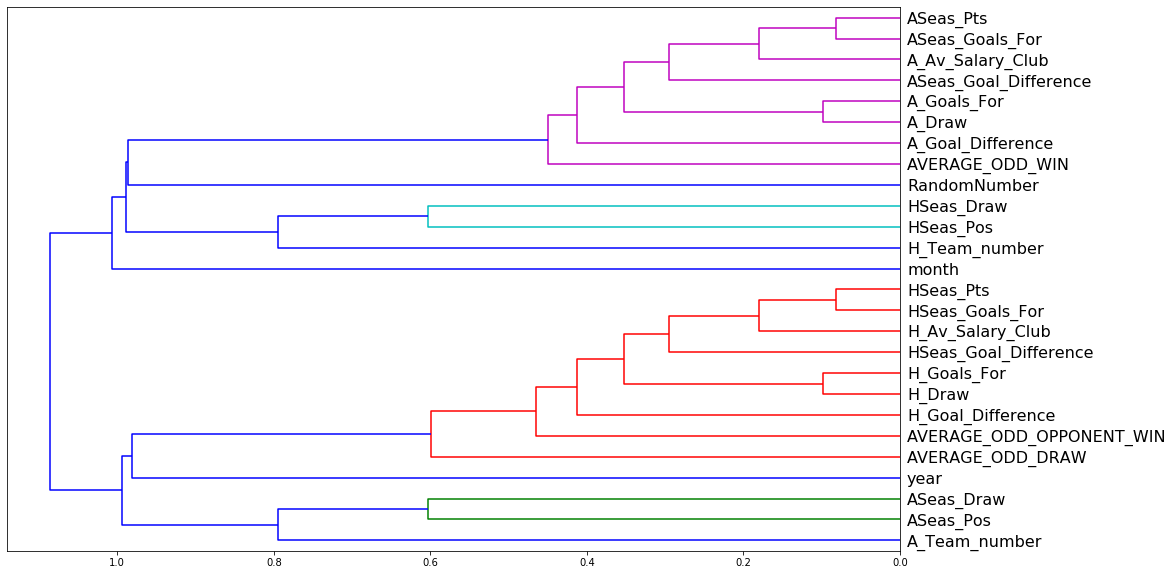

In [49]:
# Look at how the features are clustered by using the unsupervised learning method of hierarchical clustering
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns,
    orientation='left', leaf_font_size=16)
plt.show()

### Feature Importance / Selection with Random Forest

In [173]:
cm = pd.crosstab(clf.predict(X_train), y_train)
cm


outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,182,63,55
1.0,21,51,8
2.0,130,176,454


In [174]:
fi = pd.DataFrame({'Feature': list(X_train.columns),
                   'Importance': clf.feature_importances_}).\
                    sort_values('Importance', ascending = True)

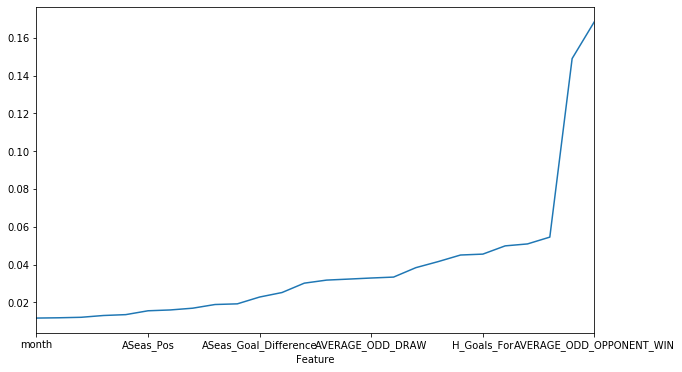

In [175]:
fi.plot('Feature', 'Importance', figsize=(10,6), legend=False);

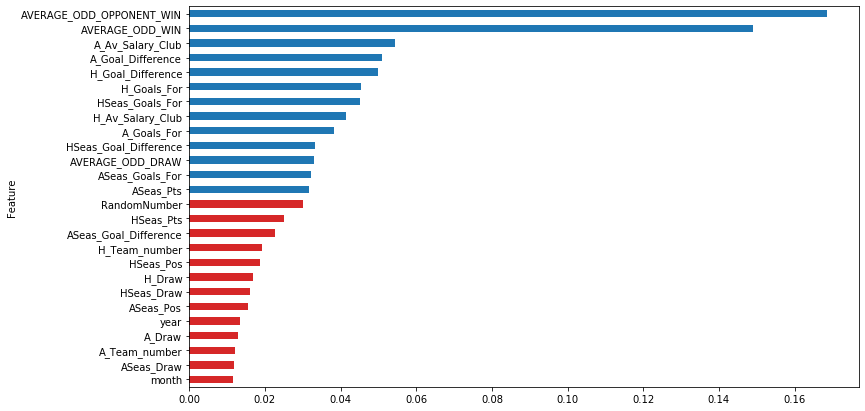

In [176]:
fi_plot = fi.plot('Feature','Importance', 'barh', figsize=(12,7), legend=False, color=['C3', 'C3','C3', 'C3', 'C3', 'C3', 'C3','C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C0', 'C0','C0', 'C0', 'C0', 'C0', 'C0', 'C0','C0', 'C0', 'C0', 'C0', 'C0'])



Keep features that are equal or less important than the random number

In [177]:
fi

,Feature,Importance
24,month,0.011665
1,ASeas_Draw,0.011817
10,A_Team_number,0.012074
12,A_Draw,0.013021
23,year,0.013483
0,ASeas_Pos,0.015522
6,HSeas_Draw,0.015962
17,H_Draw,0.016891
5,HSeas_Pos,0.018837
15,H_Team_number,0.019190


In [178]:
to_keep = fi[fi.Importance>0.031].Feature
to_keep

4                    ASeas_Pts
2              ASeas_Goals_For
21            AVERAGE_ODD_DRAW
8        HSeas_Goal_Difference
13                 A_Goals_For
16            H_Av_Salary_Club
7              HSeas_Goals_For
18                 H_Goals_For
19           H_Goal_Difference
14           A_Goal_Difference
11            A_Av_Salary_Club
20             AVERAGE_ODD_WIN
22    AVERAGE_ODD_OPPONENT_WIN
Name: Feature, dtype: object

In [179]:
X_train_keep = X_train[to_keep].copy()
X_valid_keep = X_valid[to_keep].copy()
X_test_keep = X_test[to_keep].copy()


In [180]:
X_train_keep.head()

,ASeas_Pts,ASeas_Goals_For,AVERAGE_ODD_DRAW,HSeas_Goal_Difference,A_Goals_For,H_Av_Salary_Club,HSeas_Goals_For,H_Goals_For,H_Goal_Difference,A_Goal_Difference,A_Av_Salary_Club,AVERAGE_ODD_WIN,AVERAGE_ODD_OPPONENT_WIN
0,0,0,3.5,-2,240,3.25,48,1357,46,-137,1.78,1.73,5.00
1,56,46,4.0,41,306,5.02,73,1770,768,-77,1.47,1.40,10.00
2,38,31,3.1,-9,612,2.71,46,623,-95,-292,1.14,2.00,2.70
3,38,31,3.5,0,1117,1.99,0,201,-64,-69,1.30,1.91,4.00
4,48,47,3.1,0,425,0.65,0,365,-145,-139,2.76,2.60,2.88


In [181]:
dtrain_keep = xgb.DMatrix(X_train_keep, label=y_train)
dvalid_keep = xgb.DMatrix(X_valid_keep, label=y_valid)
dtest_keep = xgb.DMatrix(X_test_keep, label=y_test)

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [182]:
df_19B20A_output.head()

,ASeas_Pos,ASeas_Draw,ASeas_Goals_For,ASeas_Goal_Difference,ASeas_Pts,HSeas_Pos,HSeas_Draw,HSeas_Goals_For,HSeas_Goal_Difference,HSeas_Pts,A_Team_number,A_Av_Salary_Club,A_Draw,A_Goals_For,A_Goal_Difference,H_Team_number,H_Av_Salary_Club,H_Draw,H_Goals_For,H_Goal_Difference,AVERAGE_ODD_WIN,AVERAGE_ODD_DRAW,AVERAGE_ODD_OPPONENT_WIN,year,month,RandomNumber
0,0,0,0,0,0,2,7,89,67,97,19,0.65,92,365,-145,14,4.86,262,1774,728,1.83,3.7,4.33,2019,8,1746
1,1,2,95,72,98,10,7,52,-3,52,15,5.99,196,1374,399,28,3.19,228,1064,-205,1.83,3.7,4.33,2019,8,1389
2,16,12,45,-20,39,15,7,45,-23,40,21,2.67,214,937,-150,5,1.60,44,190,-107,1.83,3.7,4.33,2019,8,728
3,0,0,0,0,0,4,2,67,28,71,2,1.30,275,1117,-69,25,3.52,257,1547,241,1.83,3.7,4.33,2019,8,1179
4,17,9,35,-25,36,11,8,52,-7,50,4,1.70,22,69,-45,26,1.78,51,240,-137,1.83,3.7,4.33,2019,8,1025


In [183]:
d19B20A_keep = xgb.DMatrix(df_19B20A_output, label=y_19B20A_output)

In [184]:
d19B20A_keep = xgb.DMatrix(df_19B20A_output)

In [185]:
df_19B20A_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 26 columns):
ASeas_Pos                   380 non-null int64
ASeas_Draw                  380 non-null int64
ASeas_Goals_For             380 non-null int64
ASeas_Goal_Difference       380 non-null int64
ASeas_Pts                   380 non-null int64
HSeas_Pos                   380 non-null int64
HSeas_Draw                  380 non-null int64
HSeas_Goals_For             380 non-null int64
HSeas_Goal_Difference       380 non-null int64
HSeas_Pts                   380 non-null int64
A_Team_number               380 non-null int64
A_Av_Salary_Club            380 non-null float64
A_Draw                      380 non-null int64
A_Goals_For                 380 non-null int64
A_Goal_Difference           380 non-null int64
H_Team_number               380 non-null int64
H_Av_Salary_Club            380 non-null float64
H_Draw                      380 non-null int64
H_Goals_For                 380 non-null int6

### Parameter Tuning with reduced features

In [186]:
forest = RandomForestClassifier(random_state=1)

n_estimators = [50, 100, 150]
max_depth = [1, 3, 5, 9, 12, 15]
min_samples_split = [1, 2, 3]
min_samples_leaf = [1, 6, 12, 15, 18, 24] 
bootstrap = ['False', 'True'] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,
              bootstrap = bootstrap)

gridF = GridSearchCV(forest, hyperF, verbose = 1, cv=4, n_jobs = -1)
bestF = gridF.fit(X_train_keep, y_train)



Fitting 4 folds for each of 648 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed:  2.2min finished


In [187]:
print(f'Best: {bestF.best_score_} using {bestF.best_params_}','\n')

Best: 0.5447368421052632 using {'bootstrap': 'False', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} 



In [188]:
clf_keep = RandomForestClassifier(random_state=1, n_jobs=-1, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100, bootstrap='False')
clf_keep.fit(X_train_keep, y_train)
print_score(clf_keep, X_train_keep, y_train, X_valid_keep, y_valid)



[0.9022389305052727, 0.9787209698591858, 0.6280701754385964, 0.5947368421052631]


Accuracy increases from 58% before feature selection

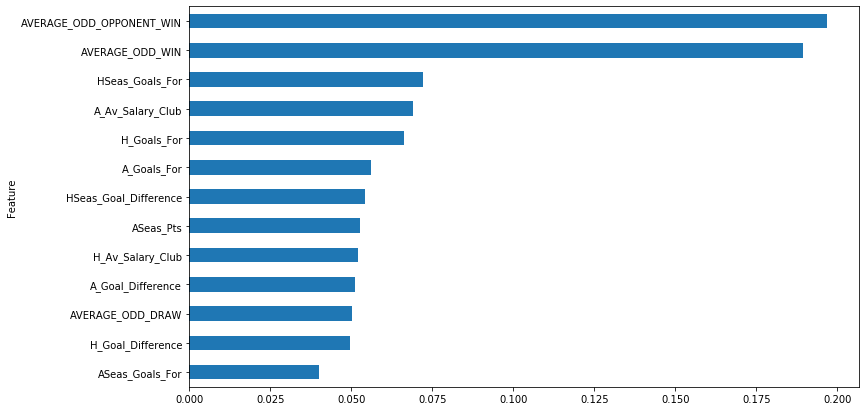

In [189]:
fi_keepvalid = pd.DataFrame({'Feature': list(X_valid_keep.columns),
                   'Importance': clf_keep.feature_importances_}).\
                    sort_values('Importance', ascending = True)
fi_plotvalid = fi_keepvalid.plot('Feature','Importance', 'barh', figsize=(12,7), legend=False, color=['C0', 'C0', 'C0', 'C0', 'C0','C0', 'C0', 'C0', 'C0', 'C0', 'C0'])


Feature important, showing the odds for the home team and the away team winning having the greatest influence on the results

In [190]:
X_valid_keep.head()

,ASeas_Pts,ASeas_Goals_For,AVERAGE_ODD_DRAW,HSeas_Goal_Difference,A_Goals_For,H_Av_Salary_Club,HSeas_Goals_For,H_Goals_For,H_Goal_Difference,A_Goal_Difference,A_Av_Salary_Club,AVERAGE_ODD_WIN,AVERAGE_ODD_OPPONENT_WIN
0,47,56,3.8,40,623,6.53,68,1989,1060,-95,2.71,1.57,6.00
1,0,0,3.5,-16,66,1.99,45,201,-64,-77,0.96,1.91,4.00
2,77,74,3.2,-8,1547,1.65,39,1249,14,241,3.52,3.80,2.05
3,49,44,3.2,0,1357,1.76,0,203,-124,46,3.25,2.30,3.20
4,44,45,3.3,0,425,1.73,0,604,-174,-139,2.76,2.45,2.80


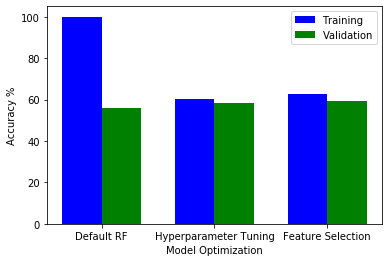

In [191]:
#%matplotlib qt
bar_width = 0.35
index = np.arange(3)
fig, ax = plt.subplots()
data_x = [0.0, 1.0, 2.0]
data_y = [100.0, 60.2, 62.8]
data_z = [55.8, 58.4, 59.5]
training = ax.bar(index, data_y, bar_width,
                label="Training", color='blue')
valid = ax.bar(index+bar_width, data_z,
                 bar_width, label="Validation", color='green')
ax.set_xlabel('Model Optimization')
ax.set_ylabel('Accuracy %')
ax.set_xticklabels(["Default RF", "Hyperparameter Tuning", "Feature Selection"])
ax.set_xticks(index + bar_width / 2)
ax.legend()
plt.show()


Plot to show the evolution of the models during the model tuning process

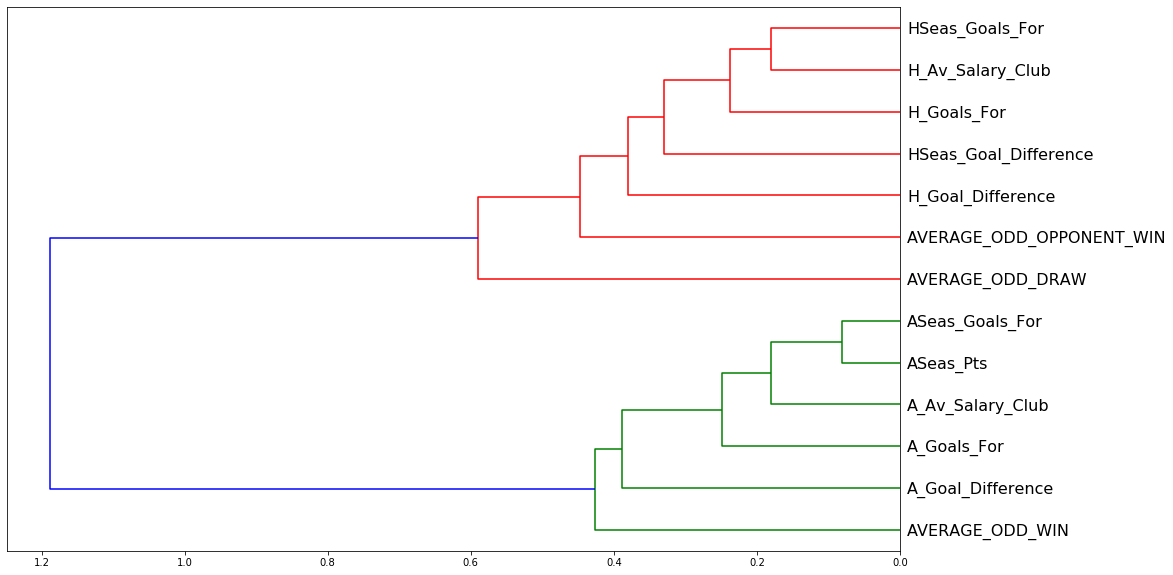

In [192]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X_train_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_keep.columns,
    orientation='left', leaf_font_size=16)
plt.show()

The hierarchical clustering confirms how we would expect these features to be clustered together

### Confusion Matrix on Validation Data with Random Forest

In [620]:
print_score(clf_keep, X_train_keep, y_train, X_valid_keep, y_valid)
print_score(clf_keep, X_train_keep, y_train, X_test_keep, y_test)

print_score(clf, X_train, y_train, X_valid, y_valid)
print_score(clf, X_train, y_train, X_test, y_test)

[0.9022389305052727, 0.9787209698591858, 0.6280701754385964, 0.5947368421052631]
[0.9022389305052727, 1.046900186264192, 0.6280701754385964, 0.528]
[0.9403246919632545, 1.0234101919819987, 0.6026315789473684, 0.5842105263157895]
[0.9403246919632545, 1.0526157893552615, 0.6026315789473684, 0.528]


The validation accuracy is ~59%, but the test accuracy is only 52.8%; look at confusion matrix for mis-classification

In [194]:
cm_validclf = pd.crosstab(clf.predict(X_valid), y_valid)
cm_validclf

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,61,9,18
1.0,5,4,6
2.0,62,58,157


In [195]:
cm_validclf_keep = pd.crosstab(clf_keep.predict(X_valid_keep), y_valid)
cm_validclf_keep

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,65,10,18
1.0,11,7,9
2.0,52,54,154


In [201]:
cm_testclf = pd.crosstab(clf.predict(X_test), y_test)
cm_testclf

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,37,14,14
1.0,3,2,0
2.0,39,48,93


In [200]:
cm_testclf_keep = pd.crosstab(clf_keep.predict(X_test_keep), y_test)
cm_testclf_keep

outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0.0,39,14,16
1.0,4,6,4
2.0,36,44,87


Reducing the number of features improved the numbef of draws predicted; although this is still an area that needs the most improvement as shown in the confusion matrix below

Text(0, 0.5, 'Predicted label')

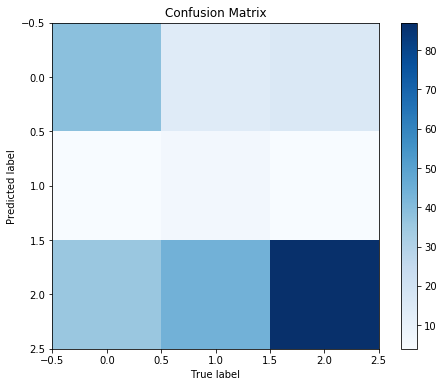

In [202]:
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(8, 6))
plt.imshow(cm_testclf_keep, cmap=cmap)
plt.title('Confusion Matrix')
plt.grid(False)
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
    

## XGB

Aim to improve accuracy of the decision tree-based model by using an XGBoost

### XGB Parameter Tuning

In [211]:
# setting up XGB and starting with default settings

param_init = {
    'silent': 1,  # logging mode - quiet default is 0
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset

In [212]:
bst_init = xgb.train(param_init, dtrain)
predstrain_init = bst_init.predict(dtrain)

bst_predstrain_init = np.asarray([np.argmax(line) for line in predstrain_init])
print(accuracy_score(y_train, bst_predstrain_init))


0.8570175438596491


In [213]:
predsvalid_init = bst_init.predict(dvalid)

bst_predsvalid_init = np.asarray([np.argmax(line) for line in predsvalid_init])
print(accuracy_score(y_valid, bst_predsvalid_init))


0.5368421052631579


The model is overfitting and need some parameter tuning

In [85]:
xgbcl = xgb.XGBClassifier(objective='multi:softprob',num_class=3)
param_grid = {
     "eta"    : [0.01, 0.04, 0.08, 0.12, 0.13, 0.14, 0.16, 0.2] ,
     "max_depth"        : [ 1, 2, 3, 4, 5, 6, 7],
     "min_child_weight" : [ 1, 3, 5, 7, 9, 10, 11, 13, 15 ],
     "gamma"            : [ 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
     "colsample_bytree" : [0.7, 0.8, 0.9, 1.0]
     }

grid_search = GridSearchCV(estimator=xgbcl,
                    param_grid=param_grid, n_jobs=-1,
                    scoring="accuracy",
                    cv=4)

grid_result = grid_search.fit(X_train_keep, y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')

Best: 0.5456140350877192 using {'colsample_bytree': 1.0, 'eta': 0.01, 'gamma': 1.5, 'max_depth': 1, 'min_child_weight': 13} 



In [709]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.11,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'min_child_weight': 10,  #
    'colsample_bytree': 1,  # 
    'gamma':1.5,
    'num_class': 3}  # the number of classes that exist in this datset
num_round=10

In [710]:
bst = xgb.train(param, dtrain_keep, num_round)

predstrain = bst.predict(dtrain_keep)
bst_predstrain = np.asarray([np.argmax(line) for line in predstrain])
print(accuracy_score(y_train, bst_predstrain))

predsvalid = bst.predict(dvalid_keep)
bst_predsvalid = np.asarray([np.argmax(line) for line in predsvalid])
print(accuracy_score(y_valid, bst_predsvalid))

predstest = bst.predict(dtest_keep)
bst_predstest = np.asarray([np.argmax(line) for line in predstest])
print(accuracy_score(y_test, bst_predstest))

0.5807017543859649
0.5657894736842105
0.564


In [711]:
predstest

array([[0.17454283, 0.20404571, 0.62141144],
       [0.523318  , 0.23216519, 0.24451683],
       [0.28617015, 0.33145717, 0.38237265],
       [0.1744296 , 0.20456207, 0.62100834],
       [0.2636053 , 0.24639896, 0.48999572],
       [0.21545   , 0.23685133, 0.5476987 ],
       [0.36264545, 0.3131797 , 0.32417482],
       [0.26601624, 0.32374892, 0.4102348 ],
       [0.39877623, 0.31378007, 0.28744376],
       [0.26658303, 0.27724275, 0.45617422],
       [0.19026636, 0.22313464, 0.586599  ],
       [0.30835518, 0.3168907 , 0.37475416],
       [0.29044384, 0.27685007, 0.4327061 ],
       [0.18360521, 0.25033233, 0.5660624 ],
       [0.28591365, 0.30273813, 0.41134822],
       [0.523318  , 0.23216519, 0.24451683],
       [0.1905405 , 0.2466183 , 0.56284124],
       [0.27201664, 0.336629  , 0.3913544 ],
       [0.18423107, 0.27156523, 0.5442037 ],
       [0.3640616 , 0.31049773, 0.3254407 ],
       [0.34430072, 0.30833888, 0.34736037],
       [0.26698738, 0.28281552, 0.4501971 ],
       [0.

In [712]:
cm_trainxgb = pd.crosstab(bst_predstrain, y_train)
cm_trainxgb


outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0,171,57,51
1,31,49,24
2,131,184,442


In [713]:
cm_validxgb = pd.crosstab(bst_predsvalid, y_valid)
cm_validxgb


outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0,61,15,23
1,9,4,8
2,58,52,150


In [714]:
cm_testxgb = pd.crosstab(bst_predstest, y_test)
cm_testxgb


outcome_by_HOME,0.0,1.0,2.0
row_0,,,
0,45,14,16
1,2,5,0
2,32,45,91


Text(0, 0.5, 'Predicted label')

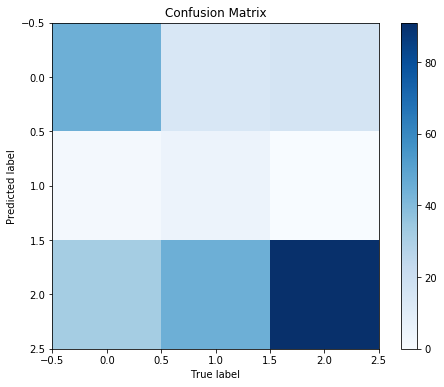

In [715]:
cmap = plt.get_cmap('Blues')
plt.figure(figsize=(8, 6))
plt.imshow(cm_testxgb, cmap=cmap)
plt.title('Confusion Matrix')
plt.grid(False)
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')


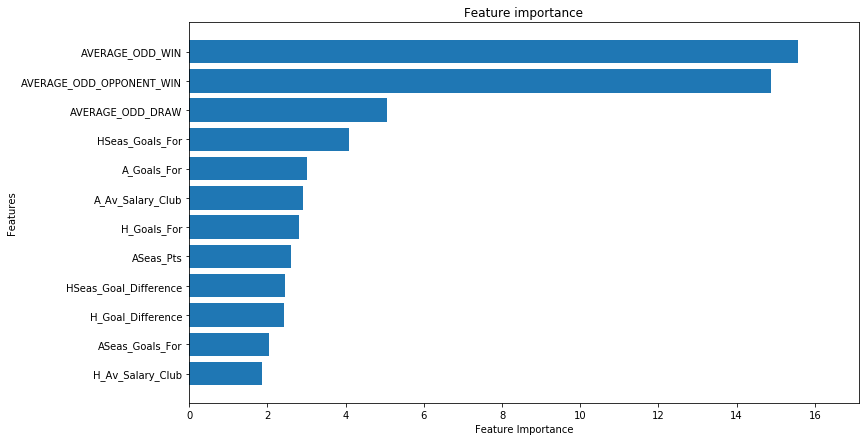

In [716]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(bst, height=0.8, ax=ax, grid=False, importance_type="gain", xlabel='Feature Importance', ylabel='Features', show_values=False, color=['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0'])
plt.show()


## Comparison against baseline methods

### RF, XGB and Log Reg

In [735]:
print_score(clf_keep, X_train_keep, y_train, X_valid_keep, y_valid)
print_score(clf_keep, X_train_keep, y_train, X_test_keep, y_test)
print_score(clf_LG_keep, X_train_keep, y_train, X_valid_keep, y_valid)
print_score(clf_LG_keep, X_train_keep, y_train, X_test_keep, y_test)

[0.9022389305052727, 0.9787209698591858, 0.6280701754385964, 0.5947368421052631]
[0.9022389305052727, 1.046900186264192, 0.6280701754385964, 0.528]
[1.0238386660187668, 1.0091684956594607, 0.5385964912280702, 0.5973684210526315]
[1.0238386660187668, 1.1009087155618307, 0.5385964912280702, 0.496]


In [736]:
print(metrics.classification_report(y_test, bst_predstest, digits=3))


              precision    recall  f1-score   support

         0.0      0.600     0.570     0.584        79
         1.0      0.714     0.078     0.141        64
         2.0      0.542     0.850     0.662       107

    accuracy                          0.564       250
   macro avg      0.619     0.499     0.462       250
weighted avg      0.604     0.564     0.504       250



### Random, Home Team and Lowest Odds

In [739]:
results = pd.DataFrame(bst_predstest)
results.rename(columns = {0:'XGB'}, inplace = True)
results.head()

,XGB
0,2
1,0
2,2
3,2
4,2


In [740]:
# Results if you predicted randomly

results['RandomNumber'] = np.random.randint(0, 3, results.shape[0])
results.head(300)

,XGB,RandomNumber
0,2,2
1,0,0
2,2,2
3,2,0
4,2,1
5,2,1
6,0,2
7,2,1
8,0,0
9,2,1


In [741]:
# Results in ~32% Accuracy, which is what we expect

print(metrics.classification_report(y_test, results['RandomNumber'], digits=3))



              precision    recall  f1-score   support

         0.0      0.291     0.316     0.303        79
         1.0      0.224     0.297     0.255        64
         2.0      0.456     0.336     0.387       107

    accuracy                          0.320       250
   macro avg      0.323     0.317     0.315       250
weighted avg      0.344     0.320     0.327       250



In [742]:
cm_testrandom = pd.crosstab(results['RandomNumber'], y_test)
cm_testrandom

outcome_by_HOME,0.0,1.0,2.0
RandomNumber,,,
0,25,21,40
1,35,19,31
2,19,24,36


In [743]:
# Predicting the home team always wins is a 42.8% accuracy

results['HomeTeamWins'] = 2
results.head()
print(metrics.classification_report(y_test, results['HomeTeamWins'], digits=3))
cm_testhome = pd.crosstab(results['HomeTeamWins'], y_test)
cm_testhome

              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000        79
         1.0      0.000     0.000     0.000        64
         2.0      0.428     1.000     0.599       107

    accuracy                          0.428       250
   macro avg      0.143     0.333     0.200       250
weighted avg      0.183     0.428     0.257       250



/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


outcome_by_HOME,0.0,1.0,2.0
HomeTeamWins,,,
2,79,64,107


In [744]:
# Always predicting a draw is 26% accurate

results['Draw'] = 1
results.head()
print(metrics.classification_report(y_test, results['Draw'], digits=3))
cm_testhome = pd.crosstab(results['Draw'], y_test)
cm_testhome

              precision    recall  f1-score   support

         0.0      0.000     0.000     0.000        79
         1.0      0.256     1.000     0.408        64
         2.0      0.000     0.000     0.000       107

    accuracy                          0.256       250
   macro avg      0.085     0.333     0.136       250
weighted avg      0.066     0.256     0.104       250



outcome_by_HOME,0.0,1.0,2.0
Draw,,,
1,79,64,107


In [745]:
# And always going with the lowest odss has a 52.8% accuracy

results['BestOdds'] = 0
results.BestOdds[(X_test_keep.AVERAGE_ODD_WIN < X_test_keep.AVERAGE_ODD_OPPONENT_WIN) & (X_test_keep.AVERAGE_ODD_WIN < X_test_keep.AVERAGE_ODD_DRAW)] = 2
results.BestOdds[(X_test_keep.AVERAGE_ODD_OPPONENT_WIN < X_test_keep.AVERAGE_ODD_WIN) & (X_test_keep.AVERAGE_ODD_OPPONENT_WIN < X_test_keep.AVERAGE_ODD_DRAW)] = 0
results.BestOdds[(X_test_keep.AVERAGE_ODD_DRAW < X_test_keep.AVERAGE_ODD_WIN) & (X_test_keep.AVERAGE_ODD_DRAW < X_test_keep.AVERAGE_ODD_OPPONENT_WIN)] = 1

print(metrics.classification_report(y_test, results['BestOdds'], digits=3))
cm_testbestodds = pd.crosstab(results['BestOdds'], y_test)
cm_testbestodds


              precision    recall  f1-score   support

         0.0      0.547     0.595     0.570        79
         1.0      0.000     0.000     0.000        64
         2.0      0.518     0.794     0.627       107

    accuracy                          0.528       250
   macro avg      0.355     0.463     0.399       250
weighted avg      0.395     0.528     0.449       250



outcome_by_HOME,0.0,1.0,2.0
BestOdds,,,
0,47,17,22
2,32,47,85


(20, 65)

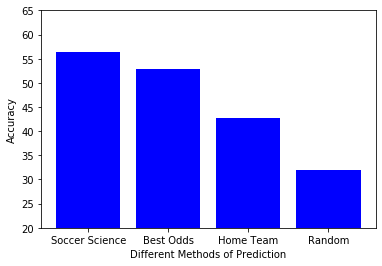

In [760]:
#%matplotlib qt
data_x = ['Soccer Science','Best Odds', 'Home Team', 'Random']
data_y = [56.4, 52.8, 42.8, 32.0]
plt.bar(data_x, data_y, color='blue')
plt.xlabel('Different Methods of Prediction')
plt.ylabel('Accuracy')
plt.ylim((20, 65))

(40, 60)

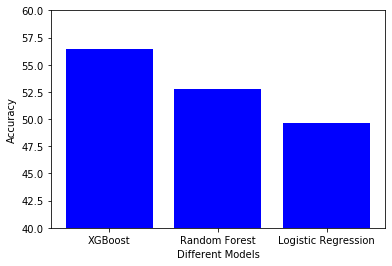

In [761]:
#%matplotlib qt
data_x = ['XGBoost','Random Forest', 'Logistic Regression']
data_y = [56.4, 52.8, 49.6]
plt.bar(data_x, data_y, color='blue')
plt.xlabel('Different Models')
plt.ylabel('Accuracy')
plt.ylim((40, 60))

### What if you bet 100 USD on each game for the current season

In [751]:
results['HomeOdds'] = X_test_keep.AVERAGE_ODD_WIN
results['AwayOdds'] = X_test_keep.AVERAGE_ODD_OPPONENT_WIN
results['DrawOdds'] = X_test.AVERAGE_ODD_DRAW
results['RF'] = clf_keep.predict(X_test_keep)
results['LogReg'] = clf_LG_keep.predict(X_test_keep)
results['Actual'] = y_test
results.head(300)

,XGB,RandomNumber,HomeTeamWins,Draw,BestOdds,HomeOdds,AwayOdds,DrawOdds,RF,LogReg,Actual
0,2,2,2,1,2,1.12,21.00,8.50,2.0,2.0,2.0
1,0,0,2,1,0,13.00,1.24,6.00,0.0,0.0,0.0
2,2,2,2,1,2,2.70,2.75,3.20,2.0,2.0,2.0
3,2,0,2,1,2,1.29,10.00,5.50,2.0,2.0,2.0
4,2,1,2,1,2,1.95,4.20,3.40,2.0,2.0,0.0
5,2,1,2,1,2,2.00,3.80,3.50,2.0,2.0,1.0
6,0,2,2,1,0,3.10,2.35,3.30,1.0,0.0,1.0
7,2,1,2,1,2,2.20,3.50,3.25,2.0,2.0,1.0
8,0,0,2,1,0,4.50,1.78,3.75,0.0,0.0,0.0
9,2,1,2,1,2,2.15,3.50,3.30,2.0,2.0,2.0


In [752]:
# Betting $25k for the season so far

bets_placed = len(results)*100
len(results)

250

In [753]:
# Going with the XGBoost model would mean you're $1281 up (>5% return on your money)

results['XGB_Outcome'] = 0
results.XGB_Outcome[(results.XGB == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.XGB_Outcome[(results.XGB == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.XGB_Outcome[(results.XGB == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_XGB = results['XGB_Outcome'].sum()
tot_winnings_XGB = winnings_XGB - bets_placed
tot_winnings_XGB

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

1281.0

In [754]:
# Going with the RF model would mean you're ~$1k down

results['RF_Outcome'] = 0
results.RF_Outcome[(results.RF == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.RF_Outcome[(results.RF == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.RF_Outcome[(results.RF == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_rf = results['RF_Outcome'].sum()
tot_winnings_rf = winnings_rf - bets_placed
tot_winnings_rf

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

-1084.0

In [765]:
# Going with the Random model would mean you're ~$2600 down

results['Random_Outcome'] = 0
results.Random_Outcome[(results.RandomNumber == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.Random_Outcome[(results.RandomNumber == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.Random_Outcome[(results.RandomNumber == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_random = results['Random_Outcome'].sum()
tot_winnings_random = winnings_random - bets_placed
tot_winnings_random

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/

25000

In [757]:
# Always predicting the home team to win would mean you're ~$801 down

results['Home_Outcome'] = 0
results.Home_Outcome[(results.HomeTeamWins == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.Home_Outcome[(results.HomeTeamWins == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.Home_Outcome[(results.HomeTeamWins == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_home = results['Home_Outcome'].sum()
tot_winnings_home = winnings_home - bets_placed
tot_winnings_home

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

-801.0

In [758]:
# Always predicting a draw would mean you're ~$34 down

results['Draw_Outcome'] = 1
results.Draw_Outcome[(results.Draw == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.Draw_Outcome[(results.Draw == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.Draw_Outcome[(results.Draw == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_draw = results['Draw_Outcome'].sum()
tot_winnings_draw = winnings_draw - bets_placed
tot_winnings_draw

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


-34.0

In [759]:
# Always going with the lowest odss would mean you're ~$1900 down

results['Odds_Outcome'] = 0
results.Odds_Outcome[(results.BestOdds == 0) & (results.Actual == 0)] = results.AwayOdds * 100
results.Odds_Outcome[(results.BestOdds == 1) & (results.Actual == 1)] = results.DrawOdds * 100
results.Odds_Outcome[(results.BestOdds == 2) & (results.Actual == 2)] = results.HomeOdds * 100
winnings_odds = results['Odds_Outcome'].sum()
tot_winnings_odds = winnings_odds - bets_placed
tot_winnings_odds

/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/fionastrobridge/opt/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.py

-1879.0

Text(0, 0.5, 'Money Outcome')

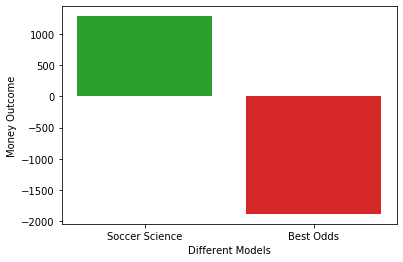

In [766]:
#%matplotlib qt
data_x = ['Soccer Science','Best Odds']
data_y = [1281.0, -1879]
plt.bar(data_x, data_y, color=['C2', 'C3'])
plt.xlabel('Different Models')
plt.ylabel('Money Outcome')

## Outputs for Web Application

In [422]:
filename = 'df_19B20A.csv'
df_19B20A_output.to_csv(filename)

In [423]:
df_19B20A_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 26 columns):
ASeas_Pos                   380 non-null int64
ASeas_Draw                  380 non-null int64
ASeas_Goals_For             380 non-null int64
ASeas_Goal_Difference       380 non-null int64
ASeas_Pts                   380 non-null int64
HSeas_Pos                   380 non-null int64
HSeas_Draw                  380 non-null int64
HSeas_Goals_For             380 non-null int64
HSeas_Goal_Difference       380 non-null int64
HSeas_Pts                   380 non-null int64
A_Team_number               380 non-null int64
A_Av_Salary_Club            380 non-null float64
A_Draw                      380 non-null int64
A_Goals_For                 380 non-null int64
A_Goal_Difference           380 non-null int64
H_Team_number               380 non-null int64
H_Av_Salary_Club            380 non-null float64
H_Draw                      380 non-null int64
H_Goals_For                 380 non-null int6

In [767]:
pickle.dump(bst, open("finalized_model.pickle.dat", "wb"))